## Inverted Index

In [74]:
!pip install -qU deeplake apify-client openai python-dotenv

/home/emanuele/V4_GUIDE_COURSE/venv/lib/python3.11/site-packages/deeplake/__init__.py:190: UserWarning: Global variable '_' of type <class 'deeplake._deeplake.Dataset'> may cause issues when using fork-based multiprocessing. Consider avoiding global variables of this type, or pass to subprocess as an agrument or by manual pickling.
  warnings.warn(
/home/emanuele/V4_GUIDE_COURSE/venv/lib/python3.11/site-packages/deeplake/__init__.py:190: UserWarning: Global variable '__' of type <class 'deeplake._deeplake.Dataset'> may cause issues when using fork-based multiprocessing. Consider avoiding global variables of this type, or pass to subprocess as an agrument or by manual pickling.
  warnings.warn(
/home/emanuele/V4_GUIDE_COURSE/venv/lib/python3.11/site-packages/deeplake/__init__.py:190: UserWarning: Global variable '___' of type <class 'deeplake._deeplake.Dataset'> may cause issues when using fork-based multiprocessing. Consider avoiding global variables of this type, or pass to subprocess


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

from apify_client import ApifyClient
os.environ['APIFY_API_TOKEN'] = os.getenv('APIFY_API_TOKEN')

In [2]:
# Initialize the ApifyClient with your API token
client = ApifyClient(os.environ["APIFY_API_TOKEN"])

# Prepare the Actor input
run_input = {
  "customGeolocation": {
    "type": "Point",
    "coordinates": [
      "-122.0800081",
      "37.39252210000001"
    ],
    "radiusKm": 2
  },
  "deeperCityScrape": False,
  "includeWebResults": False,
  "language": "en",
  "maxCrawledPlacesPerSearch": 10,
  "maxImages": 10,
  "maxReviews": 10,
  "oneReviewPerRow": False,
  "onlyDataFromSearchPage": False,
  "reviewsSort": "newest",
  "reviewsStartDate": "2022-01-01",
  "scrapeResponseFromOwnerText": False,
  "scrapeReviewId": False,
  "scrapeReviewUrl": False,
  "scrapeReviewerId": False,
  "scrapeReviewerName": False,
  "scrapeReviewerUrl": False,
  "searchStringsArray": [
    "restaurant"
  ]
}

# Run the Actor and wait for it to finish
run = client.actor("compass/crawler-google-places").call(run_input=run_input)

In [3]:
scraped_data = client.dataset(run['defaultDatasetId']).list_items().items

In [5]:
print(f"Scraped {len(scraped_data)} items")

Scraped 10 items


## 1) Create the Dataset and use Inverted Index

In [6]:
from deeplake import types, schemas
import deeplake
# Create a dataset
ds = deeplake.create("file://local_inverted_index")

In [7]:
# Add columns to the dataset
ds.add_column("restaurant_name", types.Text(index_type=types.TextIndexType.Inverted))
ds.add_column("restaurant_description", types.Text(index_type=types.TextIndexType.Inverted))

In [8]:
# Filter the data
restaurant_name = []
restaurant_description = []
for el in scraped_data:
    restaurant_name.append(el['title'])
    restaurant_description.append(el['description'])

for idx, el in enumerate(restaurant_description):
    if el == None:
        restaurant_description[idx] = "No description available"


In [10]:
# Add data to the dataset
ds.append({
    "restaurant_name": restaurant_name,
    "restaurant_description": restaurant_description,
})
ds.commit()

In [11]:
# Search the dataset
ds

Dataset(columns=(restaurant_name,restaurant_description), length=10)

In [19]:
word = 'tacos'
view = ds.query(f"SELECT * WHERE CONTAINS(restaurant_description, '{word}')")
for row in view:
    print(f"Restaurant name: {row['restaurant_name']} \nDescription: {row['restaurant_description']}")

Restaurant name: Jack in the Box 
Description: Burgers, chicken, tacos & breakfast items fill out the menu at this fast-food chain.
Restaurant name: Taco Bell 
Description: Fast-food chain serving Mexican-inspired fare such as tacos, quesadillas & nachos.


## 2) Create the Dataset and use BM25 to Retrieve the Data

In [40]:
os.environ["ACTIVELOOP_TOKEN"] = os.getenv("ACTIVELOOP_TOKEN")

In [20]:
import deeplake
from deeplake import types, schemas
# Create a dataset
# ds_bm25 = deeplake.create("al://manufe/BM25_dataset", schema=schemas.TextEmbeddings(embedding_size=768))
ds_bm25 = deeplake.create("al://manufe_test/demo_BM25_v4")


In [23]:
# Add columns to the dataset
from deeplake import types
ds_bm25.add_column("restaurant_name", types.Text(index_type=types.TextIndexType.BM25))
ds_bm25.add_column("restaurant_description", types.Text(index_type=types.TextIndexType.BM25))
ds_bm25.commit()
ds_bm25.summary()

Dataset(columns=(restaurant_name,restaurant_description), length=0)
+----------------------+-----------------+
|        column        |      type       |
+----------------------+-----------------+
|   restaurant_name    |text (bm25 Index)|
+----------------------+-----------------+
|restaurant_description|text (bm25 Index)|
+----------------------+-----------------+



In [26]:
# Add data to the dataset
ds_bm25.append({
    "restaurant_name": restaurant_name,
    "restaurant_description": restaurant_description,
})
ds_bm25.commit()
ds_bm25.summary()

Dataset(columns=(restaurant_name,restaurant_description), length=10)
+----------------------+-----------------+
|        column        |      type       |
+----------------------+-----------------+
|   restaurant_name    |text (bm25 Index)|
+----------------------+-----------------+
|restaurant_description|text (bm25 Index)|
+----------------------+-----------------+



In [31]:
ds_bm25["restaurant_description"][1]

'Long-running chain serving pizzas with customizable toppings & sauces in a simple space.'

In [79]:
query = "A restaurant where I can eat tacos"
view_bm25 = ds_bm25.query(f"SELECT * ORDER BY BM25_SIMILARITY(restaurant_description, '{query}') DESC LIMIT 100")
view_bm25

Dataset(columns=(restaurant_name,restaurant_description), length=4)

### Show the results

In [39]:
for row in view_bm25:
    print(f"Restaurant name: {row['restaurant_name']} \nDescription: {row['restaurant_description']}")

Restaurant name: Taco Bell 
Description: Fast-food chain serving Mexican-inspired fare such as tacos, quesadillas & nachos.
Restaurant name: Scratch 
Description: New American spot serving refined comfort food in a sleek, warmly lit setting.
Restaurant name: Round Table Pizza 
Description: Long-running chain serving pizzas with customizable toppings & sauces in a simple space.
Restaurant name: Jack in the Box 
Description: Burgers, chicken, tacos & breakfast items fill out the menu at this fast-food chain.


## 3) Create the Dataset and use Vector Search

In [279]:
!pip install -qU sentence-transformers


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [27]:
from sentence_transformers import SentenceTransformer

/home/emanuele/V4_GUIDE_COURSE/venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [28]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [43]:
from deeplake import types

vector_search = deeplake.create("al://manufe_test/vector_indexes_v4")

# Add columns to the dataset
vector_search.add_column(name="embedding", dtype=types.Embedding(384))
vector_search.add_column(name="restaurant_name", dtype=types.Text())
vector_search.add_column(name="restaurant_description", dtype=types.Text())
vector_search.commit()

In [44]:
# Create embeddings
embeddings_restaurant_description = model.encode(restaurant_description)
print(embeddings_restaurant_description.shape)

(10, 384)


In [45]:
# Add data to the dataset
source_text = "deeplake V4 demo"
vector_search.append({"restaurant_name": restaurant_name, "restaurant_description": restaurant_description, "embedding": embeddings_restaurant_description})
vector_search.commit()

In [46]:
vector_search.summary()

Dataset(columns=(embedding,restaurant_name,restaurant_description), length=10)
+----------------------+--------------+
|        column        |     type     |
+----------------------+--------------+
|      embedding       |embedding(384)|
+----------------------+--------------+
|   restaurant_name    |     text     |
+----------------------+--------------+
|restaurant_description|     text     |
+----------------------+--------------+



In [73]:
query = "A restaurant where I can eat pizza"
embed_query = model.encode(query)
str_query = ",".join(str(c) for c in embed_query)

In [74]:
query_vs = f"select * from (select *, cosine_similarity(embedding, ARRAY[{str_query}]) as score FROM (SELECT *, ROW_NUMBER() as row_id)) order by score desc limit 3"
view_vs = vector_search.query(query_vs)
view_vs

Dataset(columns=(embedding,restaurant_name,restaurant_description,row_id,score), length=3)

In [80]:
for row in view_vs:
    print(f"Restaurant name: {row['restaurant_name']} \nDescription: {row['restaurant_description']}")

Restaurant name: Round Table Pizza 
Description: Long-running chain serving pizzas with customizable toppings & sauces in a simple space.
Restaurant name: Jack in the Box 
Description: Burgers, chicken, tacos & breakfast items fill out the menu at this fast-food chain.
Restaurant name: Taco Bell 
Description: Fast-food chain serving Mexican-inspired fare such as tacos, quesadillas & nachos.


## 4) Perform Hybrid search

In [25]:
import deeplake

vector_search = deeplake.open("al://manufe_test/vector_indexes_v4")
ds_bm25 = deeplake.open("al://manufe_test/demo_BM25_v4")

In [29]:
query = "A restaurant where I can eat tacos"
embed_query = model.encode(query)
embedding_string = ",".join(str(c) for c in embed_query)

In [30]:
# tql_vs = f"select * from (select *, cosine_similarity(embedding, ARRAY[{embedding_string}]) as score) order by score desc limit 5"
tql_vs = f"select * from (select *, cosine_similarity(embedding, ARRAY[{embedding_string}]) as score FROM (SELECT *, ROW_NUMBER() as row_id)) order by score desc limit 5"
tql_bm25 = f"select *, BM25_SIMILARITY(restaurant_description, '{query}') as score FROM (SELECT *, ROW_NUMBER() as row_id) order by BM25_SIMILARITY(restaurant_description, '{query}') desc limit 5"

vs_results = vector_search.query(tql_vs)
bm25_results = ds_bm25.query(tql_bm25)

In [31]:
vs_results

Dataset(columns=(embedding,restaurant_name,restaurant_description,row_id,score), length=5)

In [32]:
for el_vs, el_bm25 in zip(vs_results, bm25_results):
    print(el_vs["score"], el_bm25["score"])

0.6750216 1.0470805
0.59573925 0.9551417
0.38738775 0.9551417
0.38587427 0.91497225


### Fusion method

In [33]:
import math
import numpy as np
from typing import Any, Dict, List, Optional
from pydantic import BaseModel

class Document(BaseModel):
    id: str
    data: Dict[str, Any]
    score: Optional[float] = None

def softmax(retrieved_score: list[float], max_weight: int = 700) -> Dict[str, Document]:
    # Compute the exponentials
    exp_scores = [math.exp(min(score, max_weight)) for score in retrieved_score]
    
    # Compute the sum of the exponentials
    sum_exp_scores = sum(exp_scores)

    # Update the scores of the documents using softmax
    new_weights = []
    for score in exp_scores:
        new_weights.append(score / sum_exp_scores)

    return new_weights

In [34]:
vs_results

Dataset(columns=(embedding,restaurant_name,restaurant_description,row_id,score), length=5)

### Normalize the score

In [35]:
vs_score = vs_results["score"]
bm_score = bm25_results["score"]

vss = softmax(vs_score)
bm25s = softmax(bm_score)
print(vss)
print(bm25s)

[0.24673414529662918, 0.2279278379742108, 0.18505953532268474, 0.1847796630502979, 0.1554988183561774]
[0.2702287811298398, 0.24649214924461169, 0.24649214924461169, 0.2367869203809369]


In [36]:
docs_vs = []
docs_bm25 = []
for el, score in zip(vs_results, vss):
    doc = Document(id=str(el["row_id"]), data={"restaurant_name": el["restaurant_name"], "restaurant_description": el["restaurant_description"]}, score=score)
    docs_vs.append(doc)

for el, score in zip(bm25_results, bm25s):
    doc = Document(id=str(el["row_id"]), data={"restaurant_name": el["restaurant_name"], "restaurant_description": el["restaurant_description"]}, score=score)
    docs_bm25.append(doc)

In [37]:
all_docs = docs_vs + docs_bm25
sorted_docs = sorted(all_docs, key=lambda doc: doc.score, reverse=True)

In [38]:
sorted_docs

[Document(id='6', data={'restaurant_name': 'Taco Bell', 'restaurant_description': 'Fast-food chain serving Mexican-inspired fare such as tacos, quesadillas & nachos.'}, score=0.2702287811298398),
 Document(id='6', data={'restaurant_name': 'Taco Bell', 'restaurant_description': 'Fast-food chain serving Mexican-inspired fare such as tacos, quesadillas & nachos.'}, score=0.24673414529662918),
 Document(id='8', data={'restaurant_name': 'Scratch', 'restaurant_description': 'New American spot serving refined comfort food in a sleek, warmly lit setting.'}, score=0.24649214924461169),
 Document(id='1', data={'restaurant_name': 'Round Table Pizza', 'restaurant_description': 'Long-running chain serving pizzas with customizable toppings & sauces in a simple space.'}, score=0.24649214924461169),
 Document(id='5', data={'restaurant_name': 'Jack in the Box', 'restaurant_description': 'Burgers, chicken, tacos & breakfast items fill out the menu at this fast-food chain.'}, score=0.2367869203809369),
 

### Select the top 4 unique documents

In [39]:
# Select the top 4 documents with unique ids
top_docs = []
seen_ids = set()

for doc in sorted_docs:
    if doc.id not in seen_ids:  # Check if the id has not been added yet
        top_docs.append(doc)
        seen_ids.add(doc.id)
    if len(top_docs) == 4:  # Stop when we have the top 4 unique ids
        break

In [40]:
top_docs

[Document(id='6', data={'restaurant_name': 'Taco Bell', 'restaurant_description': 'Fast-food chain serving Mexican-inspired fare such as tacos, quesadillas & nachos.'}, score=0.2702287811298398),
 Document(id='8', data={'restaurant_name': 'Scratch', 'restaurant_description': 'New American spot serving refined comfort food in a sleek, warmly lit setting.'}, score=0.24649214924461169),
 Document(id='1', data={'restaurant_name': 'Round Table Pizza', 'restaurant_description': 'Long-running chain serving pizzas with customizable toppings & sauces in a simple space.'}, score=0.24649214924461169),
 Document(id='5', data={'restaurant_name': 'Jack in the Box', 'restaurant_description': 'Burgers, chicken, tacos & breakfast items fill out the menu at this fast-food chain.'}, score=0.2367869203809369)]

### Show the results

In [49]:
for row in top_docs:
    print(f"Restaurant name: {row.data['restaurant_name']} \nDescription: {row.data['restaurant_description']}")

Restaurant name: Taco Bell 
Description: Fast-food chain serving Mexican-inspired fare such as tacos, quesadillas & nachos.
Restaurant name: Scratch 
Description: New American spot serving refined comfort food in a sleek, warmly lit setting.
Restaurant name: Round Table Pizza 
Description: Long-running chain serving pizzas with customizable toppings & sauces in a simple space.
Restaurant name: Jack in the Box 
Description: Burgers, chicken, tacos & breakfast items fill out the menu at this fast-food chain.


## 5) Work with Images

In [ ]:
!pip install -qU torch torchvision

In [4]:
scraped_data[0]["imageUrls"]
len(scraped_data)

10

In [ ]:
import os
import torch
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = models.resnet18(pretrained=True)

return_nodes = {
    'avgpool': 'embedding'
}
model = create_feature_extractor(model, return_nodes=return_nodes)

model.eval()
model.to(device)
tform= transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], dim=0) if x.shape[0] == 1 else x),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

### Create the embedding function

In [6]:
def embedding_function_images(images, model = model, transform = tform, batch_size = 4):
    """Creates a list of embeddings based on a list of image filenames. Images are processed in batches."""

    if isinstance(images, str):
        images = [images]

    #Proceess the embeddings in batches, but return everything as a single list
    embeddings = []
    for i in range(0, len(images), batch_size):
        batch = torch.stack([transform(item) for item in images[i:i+batch_size]])
        batch = batch.to(device)
        with torch.no_grad():
            embeddings+= model(batch)['embedding'][:,:,0,0].cpu().numpy().tolist()

    return embeddings

### Create a new dataset to save the images

In [130]:
from deeplake import types

dataset_name = "restaurant_images_dataset_v4"
vector_search_images = deeplake.create(f"al://manufe_test/{dataset_name}")

vector_search_images.add_column(name="embedding", dtype=types.Embedding(512))
vector_search_images.add_column(name="restaurant_name", dtype=types.Text())
vector_search_images.add_column(name="image", dtype=types.Image(dtype=types.UInt8()))

vector_search_images.commit()

### Convert the URLs into images

In [11]:
from PIL import Image
import requests
from io import BytesIO

restaurants_images = []

for el in scraped_data:
    urls = el["imageUrls"]
    responses = [response for response in [requests.get(url) for url in urls] if response.status_code == 200]
    pil_images = [Image.open(BytesIO(response.content)) for response in responses]
    restaurants_images.append(pil_images)


In [14]:
source_text = "deeplake V4 demo"

for sd, rest_images in zip(scraped_data, restaurants_images):
    restaurant_name = [sd["title"]] * len(rest_images)
    embeddings = embedding_function_images(rest_images, model=model, transform=tform, batch_size=4)
    vector_search_images.append({"restaurant_name": restaurant_name, "image": [np.array(fn).astype(np.uint8) for fn in rest_images], "embedding": embeddings})

vector_search_images.commit()

### Search Similar Images

In [17]:
dataset_name = "restaurant_images_dataset_v4"
vector_search_images = deeplake.open(f"al://manufe_test/{dataset_name}")

In [ ]:
from PIL import Image
import requests

query = "https://www.moltofood.it/wp-content/uploads/2024/09/Hamburger.jpg"

image_query = requests.get(query)
image_query_pil = Image.open(BytesIO(image_query.content))

### Searching for images similar to the one below

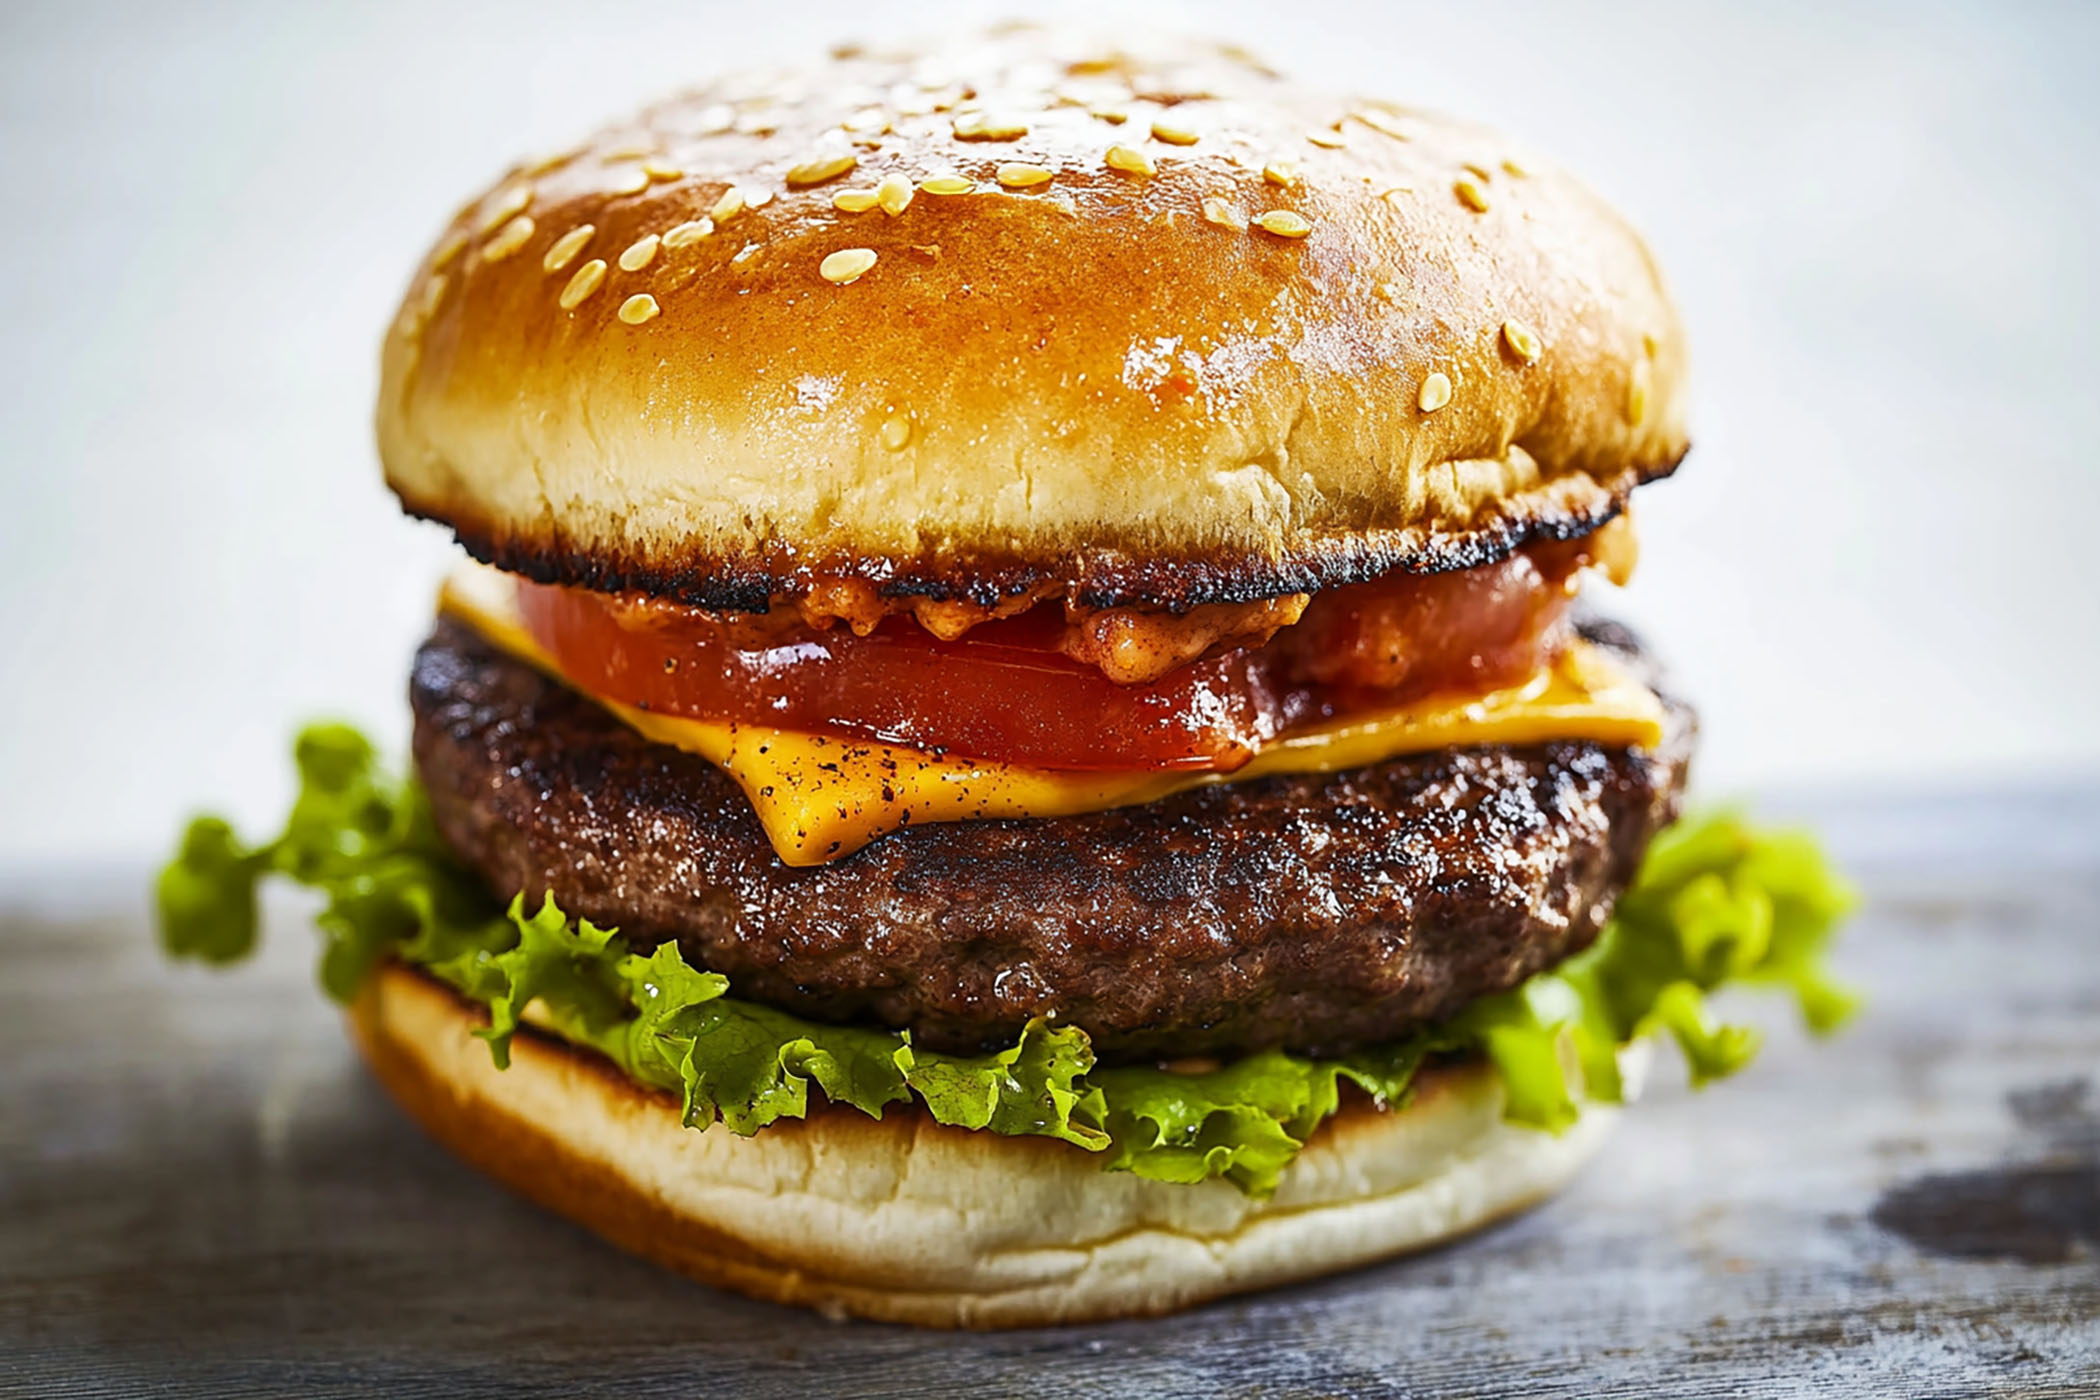

In [23]:
image_query_pil.show()

In [18]:

query_embedding = embedding_function_images([image_query_pil])[0]
query_embedding_string = ",".join([str(item) for item in query_embedding])

# tql = f"select * from (select *, cosine_similarity(embedding, ARRAY[{query_embedding_string}]) as score) order by score desc limit 6"
tql = f"select * from (select *, cosine_similarity(embedding, ARRAY[{query_embedding_string}]) as score FROM (SELECT *, ROW_NUMBER() as row_id)) order by score desc limit 6"

In [22]:
similar_images_result = vector_search_images.query(tql)
similar_images_result

Dataset(columns=(embedding,restaurant_name,image,row_id,score), length=6)

### Show similar images and the restaurants where they were taken

In [ ]:
!pip install -q matplotlib

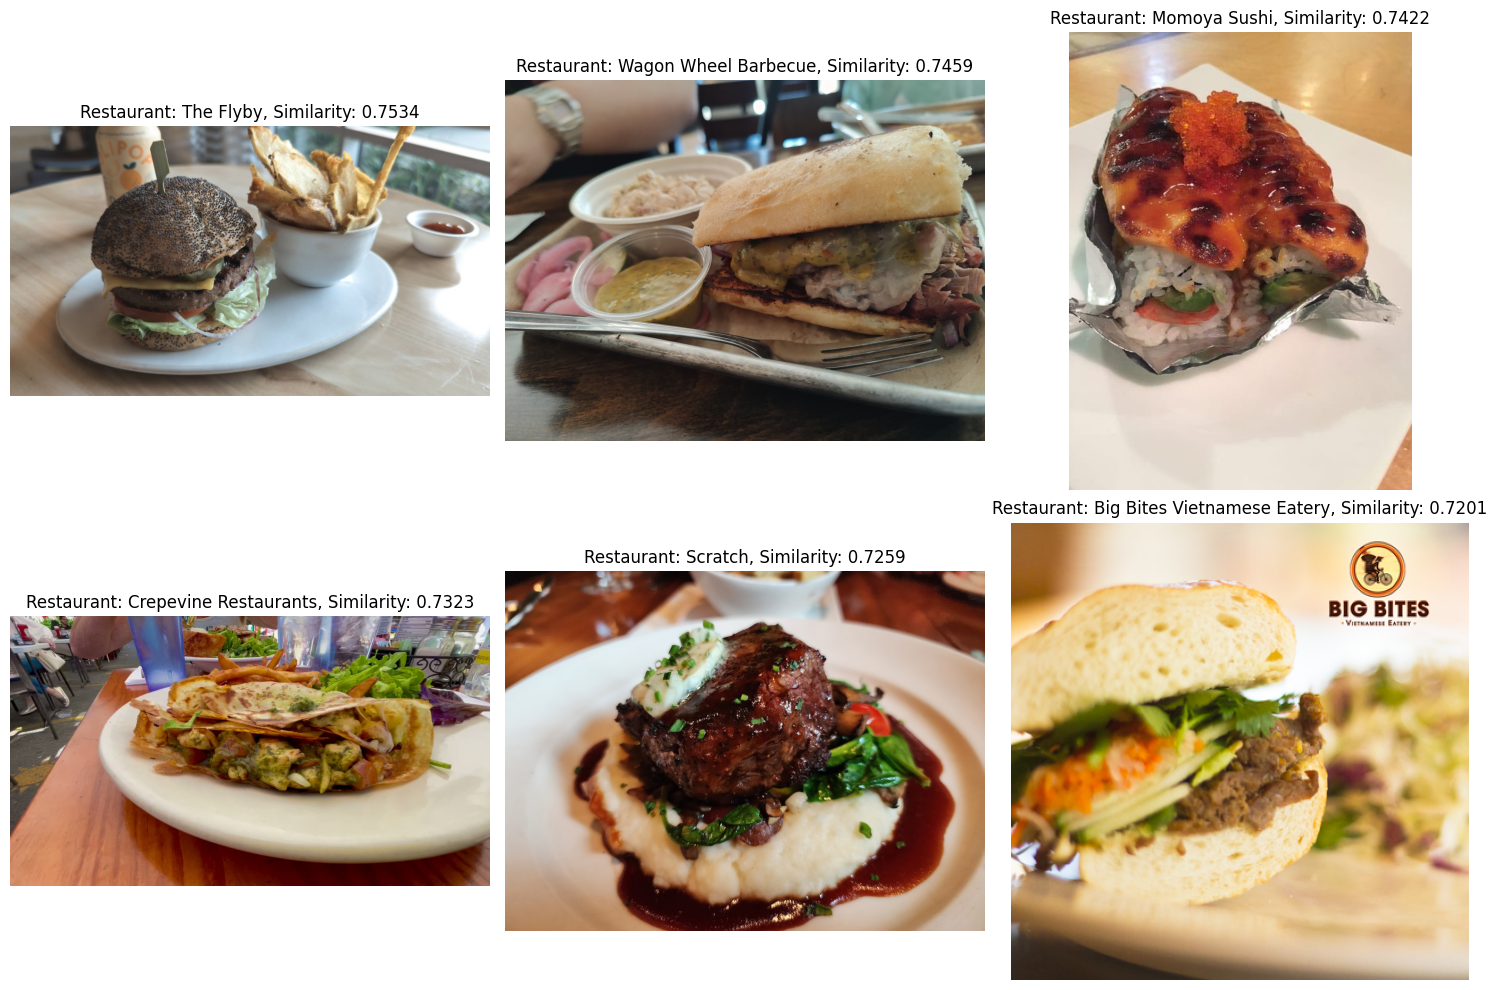

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_images(similar_images: list[dict]):
    # Define the number of rows and columns for the grid
    num_columns = 3
    num_rows = (len(similar_images) + num_columns - 1) // num_columns  # Calculate the required number of rows

    # Create the grid
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten for easier access to cells

    for idx, el in enumerate(similar_images):
        img = Image.fromarray(el["image"])
        axes[idx].imshow(img)
        axes[idx].set_title(f"Restaurant: {el['restaurant_name']}, Similarity: {el['score']:.4f}")
        axes[idx].axis('off')  # Turn off axes for a cleaner look

    # Remove empty axes if the number of images doesn't fill the grid
    for ax in axes[len(similar_images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_images(similar_images_result)

## 6) Discover Images Using ColPali and the Late Interaction Mechanism

In [ ]:
!pip install -q colpali-engine accelerate

### Download the ColPali model from Hugging Face

In [136]:
import torch
from PIL import Image

from colpali_engine.models import ColPali, ColPaliProcessor

model_name = "vidore/colpali-v1.2"

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # or "mps" if on Apple Silicon
).eval()

processor = ColPaliProcessor.from_pretrained(model_name)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [01:27<00:00, 43.72s/it]


In [7]:
from PIL import Image
import requests
from io import BytesIO

restaurants_images = []

for el in scraped_data:
    urls = el["imageUrls"]
    responses = [response for response in [requests.get(url) for url in urls] if response.status_code == 200]
    pil_images = [Image.open(BytesIO(response.content)) for response in responses]
    restaurants_images.append(pil_images)

### Create a new dataset to store the ColPali embeddings

In [66]:
from deeplake import types


vector_search_images = deeplake.create("al://manufe_test/restaurant_images_dataset_colpali7")

vector_search_images.add_column(name="embedding", dtype=types.Array(types.Float32(),dimensions=2))
vector_search_images.add_column(name="restaurant_name", dtype=types.Text())
vector_search_images.add_column(name="image", dtype=types.Image(dtype=types.UInt8()))

vector_search_images.commit()

### Save the data in the dataset 

In [ ]:
source_text = "deeplake V4 ColPali"
batch_size = 2

for sd, rest_images in zip(scraped_data, restaurants_images):
    restaurant_name = [sd["title"]] * len(rest_images)
    matrix_embeddings: list[torch.Tensor] = []
    for i in range(0, len(rest_images), batch_size):
        batch = rest_images[i:i + batch_size]  # Take batch_size images at a time
        batch_images = processor.process_images(batch).to(model.device)
        with torch.no_grad():
            embeddings = model(**batch_images)
            matrix_embeddings.extend(
                list(torch.unbind(embeddings.to("cpu")))
            )
    matrix_embeddings_list = [embedding.tolist() for embedding in matrix_embeddings]
    vector_search_images.append({"restaurant_name": restaurant_name, "image": [np.array(fn).astype(np.uint8) for fn in rest_images], "embedding": matrix_embeddings_list})

vector_search_images.commit()

### Chat with images


In [ ]:
queries = [
    "where I can eat an hamburger?",
    "where I can eat Tapas?",
]
batch_queries = processor.process_queries(queries).to(model.device)
with torch.no_grad():
    query_embeddings = model(**batch_queries)
query_embeddings = query_embeddings.tolist()

### Retrieve the most similar images

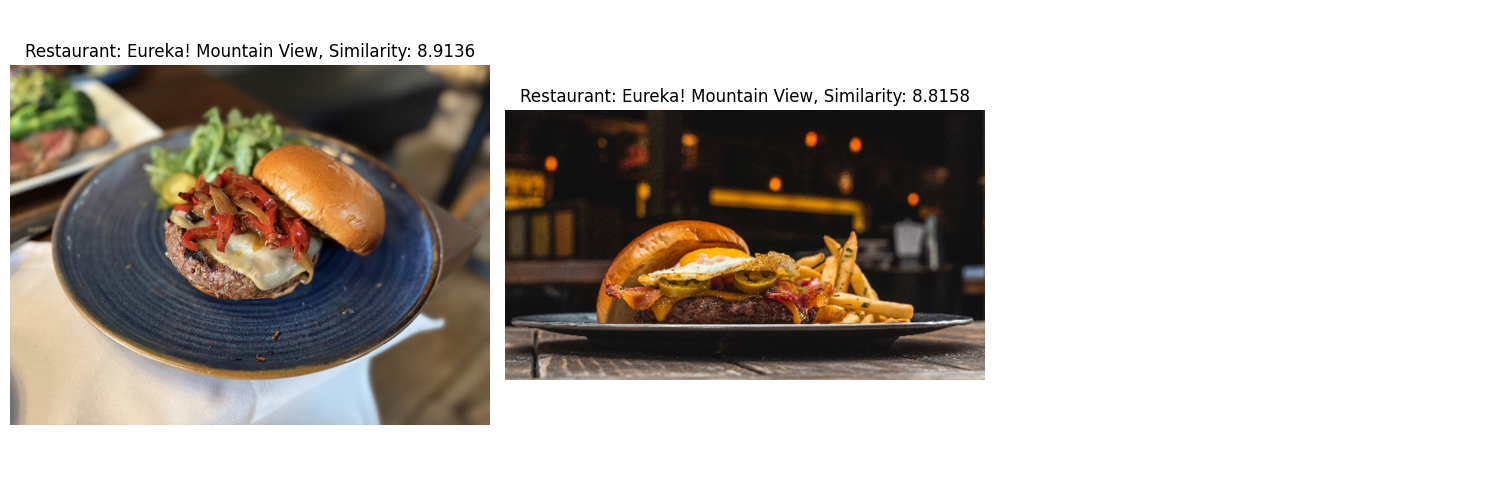

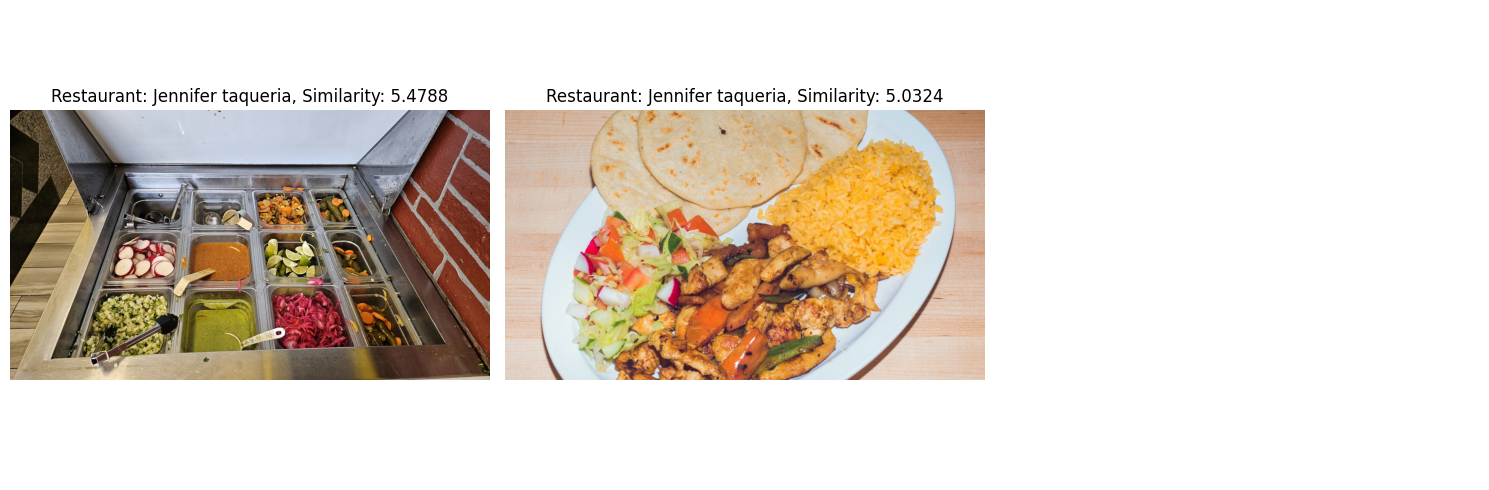

In [30]:
for el in query_embeddings:
    q_substrs = [f"ARRAY[{','.join(str(x) for x in sq)}]" for sq in el]
    q_str = f"ARRAY[{','.join(q_substrs)}]"
    view = vector_search_images.query(
        f"SELECT *, maxsim({q_str}, embedding) as score ORDER BY maxsim({q_str}, embedding) DESC LIMIT 2"
    )
    show_images(view)